In [2]:
import sys
sys.path.append('..')

In [3]:
import planetengine
import modelscripts

In [131]:
import underworld as uw
from underworld import function as fn
import math
import numpy as np

from planetengine.utilities import Grouper

def build(
        res = 64,
        f = 0.54,
        aspect = 1.,
        periodic = False,
        heating = 0.,
        Ra = 1e7,
        ):

    ### HOUSEKEEPING: IMPORTANT! ###

    inputs = locals().copy()
#     script = __file__

    ### MESH & MESH VARIABLES ###

    f = max(0.00001, min(0.99999, f))
    inputs['f'] = f

    length = 1.
    outerRad = 1. / (1. - f)
    radii = (outerRad - length, outerRad)

    maxAspect = math.pi * sum(radii) / length
    aspect = min(aspect, maxAspect)
    inputs['aspect'] = aspect
    if aspect == maxAspect:
        periodic = True
        inputs['periodic'] = periodic

    width = length**2 * aspect * 2. / (radii[1]**2 - radii[0]**2)
    midpoint = math.pi / 2.
    angExtentRaw = (midpoint - 0.5 * width, midpoint + 0.5 * width)
    angExtentDeg = [item * 180. / math.pi for item in angExtentRaw]
    angularExtent = [
        max(0., angExtentDeg[0]),
        min(360., angExtentDeg[1] + abs(min(0., angExtentDeg[0])))
        ]
    angLen = angExtentRaw[1] - angExtentRaw[0]

    radRes = max(4, int(res / 4) * 4)
    inputs['res'] = radRes
    angRes = 4 * int(angLen * (int(radRes * radii[1] / length)) / 4)
    elementRes = (radRes, angRes)

    mesh = uw.mesh.FeMesh_Annulus(
        elementRes = elementRes,
        radialLengths = radii,
        angularExtent = angularExtent,
        periodic = [False, periodic]
        )

    pressureField = uw.mesh.MeshVariable(mesh.subMesh, 1)
    velocityField = uw.mesh.MeshVariable(mesh, 2)

    swarm = uw.swarm.Swarm(mesh = mesh, particleEscape = True)
    swarm.populate_using_layout(
        uw.swarm.layouts.PerCellSpaceFillerLayout(
            swarm, 12
            )
        )
    materialVar = swarm.add_variable(dataType = "int", count = 1)

    repopulator = uw.swarm.PopulationControl(
        swarm,
        aggressive = True,
        splitThreshold = 0.15,
        maxDeletions = 2,
        maxSplits = 10,
        particlesPerCell = 10
        )

    ### BOUNDARIES ###
    
    inner = mesh.specialSets["inner"]
    outer = mesh.specialSets["outer"]
    sides = mesh.specialSets["MaxJ_VertexSet"] + mesh.specialSets["MinJ_VertexSet"]

    if periodic:
        velBC = uw.conditions.RotatedDirichletCondition(
            variable = velocityField,
            indexSetsPerDof = (inner + outer, None),
            basis_vectors = (mesh.bnd_vec_normal, mesh.bnd_vec_tangent)
            )
    else:
        velBC = uw.conditions.RotatedDirichletCondition(
            variable = velocityField,
            indexSetsPerDof = (inner + outer, sides),
            basis_vectors = (mesh.bnd_vec_normal, mesh.bnd_vec_tangent)
            )

    ### FUNCTIONS ###

    depthFn = mesh.radialLengths[1] - mesh.radiusFn

    angExtentsRadians = np.array(mesh.angularExtent) * np.pi / 180.
    radWidth = angExtentsRadians[1] - angExtentsRadians[0]
    xFn, yFn = fn.input()[0], fn.input()[1]
    magnitudeFn = fn.math.sqrt(fn.math.pow(xFn, 2) + fn.math.pow(yFn, 2))
    rawAngFn = angFn = - 2. * fn.math.atan(yFn / ((magnitudeFn) + xFn))
    angFn = (rawAngFn + angExtentsRadians[1]) / radWidth

    matBuoyFn = fn.branching.map(
        fn_key = materialVar,
        mapping = {
            0: 1.,
            1: 2.,
            2: 2.,
            3: 3.,
            }
        )

    axis = 0.3
    lDist = axis
    rDist = 1 - axis
    plateLen = fn.branching.conditional([
        (angFn < axis, lDist),
        (True, rDist)
        ])
    distFromAxis = fn.math.abs(angFn - axis)
    angBuoy = fn.math.log(distFromAxis / plateLen + 1.)
    depthBuoy = fn.math.log(depthFn + 1.)
    buoyancyFn = Ra * depthFn * angBuoy * matBuoyFn + 1.

    ### RHEOLOGY ###

    vc = uw.mesh.MeshVariable(mesh = mesh, nodeDofCount = 2)
    vc_eqNum = uw.systems.sle.EqNumber(vc, False )
    vcVec = uw.systems.sle.SolutionVector(vc, vc_eqNum)

    viscosityFn = matBuoyFn**2.

    ### SYSTEMS ###

    stokes = uw.systems.Stokes(
        velocityField = velocityField,
        pressureField = pressureField,
        conditions = [velBC,],
        fn_viscosity = viscosityFn,
        fn_bodyforce = buoyancyFn * mesh.unitvec_r_Fn,
        _removeBCs = False,
        )

    solver = uw.systems.Solver(stokes)

    advector = uw.systems.SwarmAdvector(
        swarm = swarm,
        velocityField = vc,
        order = 2,
        )

    step = fn.misc.constant(0)
    modeltime = fn.misc.constant(0.)

    ### SOLVING ###

    def postSolve():
        # realign solution using the rotation matrix on stokes
        uw.libUnderworld.Underworld.AXequalsY(
            stokes._rot._cself,
            stokes._velocitySol._cself,
            vcVec._cself,
            False
            )
        # remove null space - the solid body rotation velocity contribution
        uw.libUnderworld.StgFEM.SolutionVector_RemoveVectorSpace(
            stokes._velocitySol._cself, 
            stokes._vnsVec._cself
            )

    def solve():
        velocityField.data[:] = 0.
        solver.solve(
            callback_post_solve = postSolve,
            )
        uw.libUnderworld.Underworld.AXequalsX(
            stokes._rot._cself,
            stokes._velocitySol._cself,
            False
            )

    def integrate():
        dt = advector.get_max_dt()
        advector.integrate(dt)
        repopulator.repopulate()
        modeltime.value += dt
        step.value += 1

    def iterate():
        integrate()
        solve()

    ### HOUSEKEEPING: IMPORTANT! ###

    varsOfState = {'materialVar': materialVar}

    return Grouper(locals())

In [132]:
system = build(aspect = 2., res = 32, Ra = 1.)

In [133]:
planetengine.shapes.trapezoid

<function planetengine.shapes.trapezoid(centre=0.5, longwidth=0.3, shortwidth=0.2, thickness=0.1, skew=0.0, location='surface', lengthRatio=None, taper=None, thicknessRatio=None)>

In [134]:
initials = {
    'materialVar': {
        'IC': planetengine.initials.extents.IC(
            ([1], planetengine.shapes.trapezoid(longwidth = 0.3, lengthRatio = 1., centre = 0.15)),
            ([2], planetengine.shapes.trapezoid(longwidth = 0.7, lengthRatio = 1., centre = 0.65)),
            ([3], planetengine.shapes.trapezoid(longwidth = 0.1, lengthRatio = 1., centre = 0.5, thickness = 0.05)),
            )
        }
    }

In [135]:
planetengine.initials.apply(initials, system)

In [136]:
system.solve()

Fitted 3 variables to the figure.



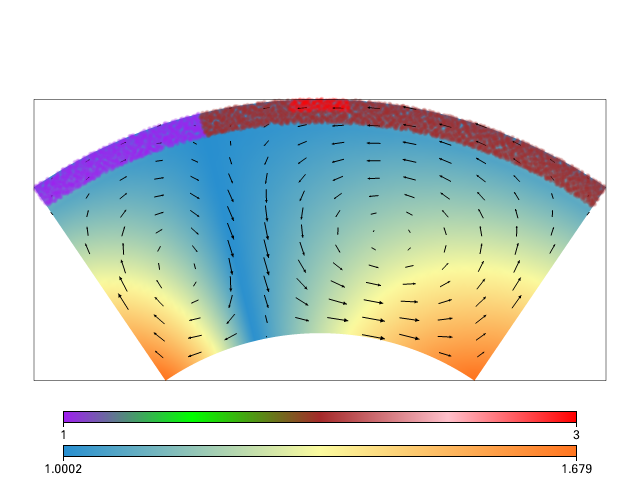

In [137]:
planetengine.quickShow(system.buoyancyFn, system.velocityField, system.materialVar)

In [146]:
for i in range(10000):
    system.iterate()

KeyboardInterrupt: 

In [147]:
planetengine.quickShow(system.buoyancyFn, system.velocityField, system.materialVar)

Fitted 3 variables to the figure.
LavaVu Run error: Failed to open X display


